In [ ]:
# Install necessary libraries
!pip install -q datasets transformers
!pip install -U accelerate
!pip install -U transformers
!pip install evaluate
!pip install onnx-tf



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import evaluate
from datasets import load_dataset

In [ ]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Import pretrained model and set training parameters

Edit - learning rate updated after Optuna trial (see last code snippet)

In [ ]:

# Setup: Specify model checkpoint, batch size, epochs, and learning rate.
model_checkpoint = "Muzmmillcoste/finetuned-dermnet"  # Pre-trained model checkpoint
batch_size = 32
num_epochs = 10
learning_rate = 1.364765882095971e-05

In [ ]:
# Try mounting to a subdirectory within /content/drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Load Dataset

In [ ]:
ds = load_dataset("Muzmmillcoste/dermnet")
metric = evaluate.load("accuracy")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13223 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2334 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13223
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2334
    })
})

In [ ]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'], id=None)}

In [ ]:
# Explore the dataset
print(ds)
print(ds["train"].features)

example = ds["train"][10]
print(example)
print("Image:", example['image'])
print("Label:", example['label'])

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13223
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2334
    })
})
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'S

# Map label names

In [ ]:
# Create label mappings.
# Create label mappings.
labels = ds["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
print("Example mapping:", id2label[2])

Example mapping: Atopic Dermatitis Photos


# Import Hugging Face Image processing pipeline

In [ ]:
# %%
from transformers import AutoImageProcessor
# Load the image processor from the model checkpoint.
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
print(image_processor)

preprocessor_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Define torchvision transforms based on the image processor

In [ ]:

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)


In [ ]:


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
else:  # use shortest_edge if available
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)


train_transforms = Compose([
    RandomResizedCrop(crop_size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

# Validation transforms.
val_transforms = Compose([
    Resize(size),
    CenterCrop(crop_size),
    ToTensor(),
    normalize,
])

# Preprocessing functions to apply transforms to each batch.
def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch


# Test Train Split + Load

In [ ]:

# Split the training set into training and validation (90/10 split).
splits = ds["train"].train_test_split(test_size=0.25, seed=42)
train_ds = splits['train']
val_ds = splits['test']

# Apply preprocessing transforms.
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [ ]:
# Define a collate function for DataLoader.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Create DataLoaders.
# Create DataLoaders with updated batch size
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



# Load the Model

In [ ]:
from transformers import AutoModelForImageClassification
# Load the pre-trained classification model.
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
print(model)

config.json:   0%|          | 0.00/2.91k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Define loss and optimizer.
# Define loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)



In [ ]:
# Calculate total training steps and set warmup steps (10% of total steps).
total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.13284 * total_steps)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps))


In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps)
)

In [ ]:
gradient_accumulation_steps = 4


# Train

In [ ]:
from tqdm import tqdm
import numpy as np

# Define gradient accumulation steps (target total batch size = 32*4 = 128)
gradient_accumulation_steps = 4

# Lists to store metrics for each epoch.
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()

early_stop = False  # Flag for early stopping

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    total_train = 0
    optimizer.zero_grad()  # Initialize gradients at the start of each epoch

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        # Scale the loss for gradient accumulation.
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Accumulate the true (unscaled) loss.
        running_loss += loss.item() * inputs.size(0) * gradient_accumulation_steps

        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total_train += inputs.size(0)

        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()  # Update scheduler only when optimizer steps

    # Final optimizer step if remaining batches.
    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    train_epoch_loss = running_loss / total_train
    train_epoch_acc = running_correct / total_train
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_epoch_loss:.4f} - Training Acc: {train_epoch_acc:.4f}")

    # Validation Loop.
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    total_val = 0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        val_running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        val_correct += (preds == labels).sum().item()
        total_val += inputs.size(0)

    val_epoch_loss = val_running_loss / total_val
    val_epoch_acc = val_correct / total_val
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Acc: {val_epoch_acc:.4f}")

    # Early stopping condition.
    if val_epoch_acc >= 0.96:
        print(f"Early stopping: Validation Accuracy reached {val_epoch_acc:.4f} at epoch {epoch+1}")
        early_stop = True
        break

    model.train()

if not early_stop:
    print("Training completed without early stopping.")


Epoch 1/10 - Training Loss: 0.2310 - Training Acc: 0.9256


Epoch 1/10 - Validation Loss: 0.0912 - Validation Acc: 0.9688
Early stopping: Validation Accuracy reached 0.9688 at epoch 1


In [ ]:
print(image_processor.image_mean)
print(image_processor.image_std)
print(image_processor.size)

[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
{'height': 224, 'width': 224}


Confusion Matrix:
[[118   0   0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0
    1   0   0   0   0]
 [  0 139   0   0   0   0   1   0   0   1   0   0   0   0   0   0   2   0
    0   0   0   0   0]
 [  0   0  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0]
 [  0   0   0  46   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1]
 [  0   0   0   0  14   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0 116   1   0   0   0   0   0   0   0   2   0   0   0
    0   0   0   1   0]
 [  0   0   0   0   0   1  33   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0  34   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  29   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0  57   1   0   0   0   0   0   0   0
    0   1   0   0   0]
 [  0   0   

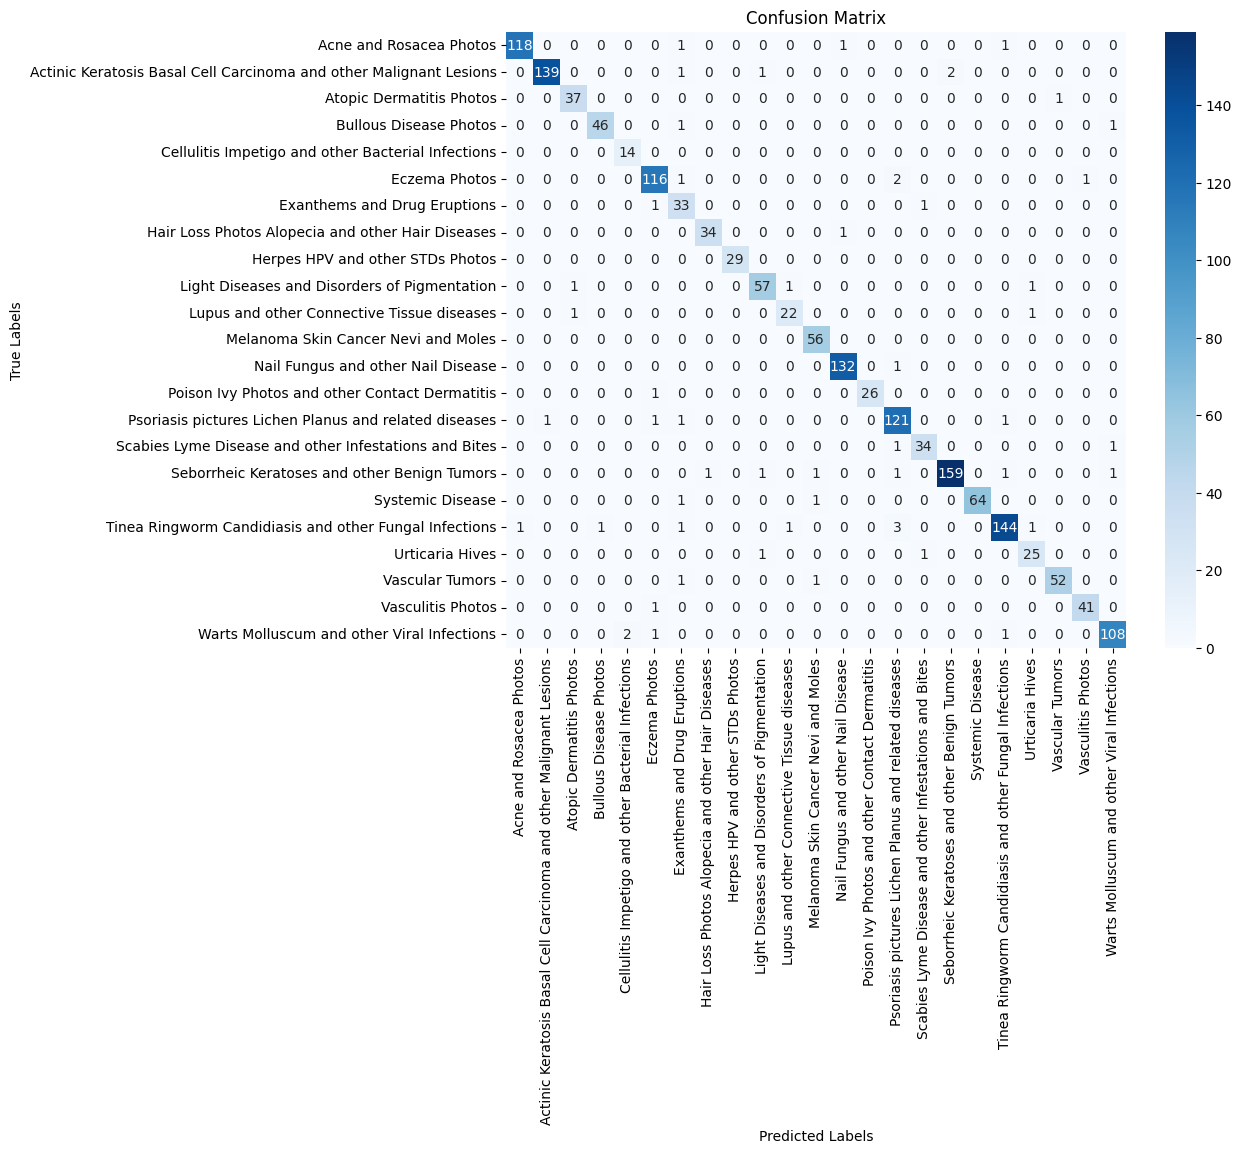

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.99      0.98      0.98       121
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.99      0.97      0.98       143
                                          Atopic Dermatitis Photos       0.95      0.97      0.96        38
                                            Bullous Disease Photos       0.98      0.96      0.97        48
                Cellulitis Impetigo and other Bacterial Infections       0.88      1.00      0.93        14
                                                     Eczema Photos       0.96      0.97      0.96       120
                                      Exanthems and Drug Eruptions       0.80      0.94      0.87        35
                 Hair Loss Photos Alopecia and other Hair Diseases       0.97      0.97      0.97        35
    

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=ds["train"].features["label"].names,
            yticklabels=ds["train"].features["label"].names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate the classification report
report = classification_report(actual_labels, predicted_labels,
                               target_names=ds["train"].features["label"].names)
print("Classification Report:")
print(report)


# Save Model

In [ ]:
# Save the model locally (to your Google Drive).
save_path = "/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft"
model.save_pretrained(save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft


# Test Model

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Define the path to your test folder.
test_folder = "/content/drive/MyDrive/extracted_skin/Dermnet/Test_Folder"

# Use the validation transforms (assumed defined as val_transforms) for test images.
# If you already have a preprocess_val function, you can also create a transform pipeline equivalent.
# For example:
# val_transforms = Compose([
#     Resize(size),
#     CenterCrop(crop_size),
#     ToTensor(),
#     normalize,
# ])

# Create an ImageFolder dataset from the test folder.
test_ds = ImageFolder(root=test_folder, transform=val_transforms)

# Create a DataLoader for the test dataset.
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Run inference and compute accuracy.
model.eval()
predicted_labels = []
actual_labels = []

for batch in tqdm(test_loader, desc="Testing", leave=False):
    inputs, labels = batch
    inputs = inputs.to(device)
    outputs = model(inputs).logits
    preds = outputs.argmax(dim=1)
    predicted_labels.extend(preds.cpu().numpy())
    actual_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9669


# Find best parameters
After parameters are found the model is updated and run for one epoch/> 96% validation score

In [ ]:
# !pip install optuna

# import optuna
# import optuna
# from sklearn.metrics import accuracy_score  # <-- Add this import
# import torch
# import numpy as np

# def objective(trial):
#     # Suggest hyperparameters.
#     lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
#     warmup_ratio = trial.suggest_uniform('warmup_ratio', 0.05, 0.2)
#     # Optionally, you could suggest dropout rate if your model has dropout layers.

#     # Reinitialize optimizer with suggested learning rate.
#     optimizer_trial = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
#     total_steps_trial = num_epochs * len(train_loader)
#     warmup_steps_trial = int(warmup_ratio * total_steps_trial)
#     scheduler_trial = torch.optim.lr_scheduler.LambdaLR(
#         optimizer_trial, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps_trial)
#     )

#     # Run a mini training loop for 2 epochs for a quick evaluation.
#     mini_epochs = 2
#     model.train()
#     for epoch in range(mini_epochs):
#         running_loss = 0.0
#         for i, batch in enumerate(train_loader):
#             inputs = batch["pixel_values"].to(device)
#             labels = batch["labels"].to(device)
#             optimizer_trial.zero_grad()
#             outputs = model(inputs).logits
#             loss = criterion(outputs, labels)
#             loss = loss / gradient_accumulation_steps
#             loss.backward()
#             if (i + 1) % gradient_accumulation_steps == 0:
#                 optimizer_trial.step()
#                 optimizer_trial.zero_grad()
#                 scheduler_trial.step()
#             running_loss += loss.item() * inputs.size(0) * gradient_accumulation_steps

#     # Evaluate on the validation set.
#     model.eval()
#     all_preds, all_labels = [], []
#     for batch in val_loader:
#         inputs = batch["pixel_values"].to(device)
#         labels = batch["labels"].to(device)
#         outputs = model(inputs).logits
#         preds = outputs.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
#     val_acc = accuracy_score(np.array(all_labels), np.array(all_preds))
#     return val_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=5)
# print("Best hyperparameters:", study.best_trial.params)


[I 2025-03-13 16:00:23,800] A new study created in memory with name: no-name-0ec5248d-a10b-4721-86b7-f649a0a9f322
<ipython-input-32-e8a8ce401e89>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
<ipython-input-32-e8a8ce401e89>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  warmup_ratio = trial.suggest_uniform('warmup_ratio', 0.05, 0.2)
[I 2025-03-13 16:03:14,234] Trial 0 finished with value: 0.9417989417989417 and parameters: {'learning_rate': 6.343380113760466e-05, 'warmup_ratio': 0.08140093596802173}. Best is trial 0 with value: 0.9417989417989417.
<ipython-input-32-e8a8ce401e89>:11: FutureWarning: suggest_loguniform has be

Best hyperparameters: {'learning_rate': 1.364765882095971e-05, 'warmup_ratio': 0.1328402090394552}


## Import model & Convert to ONNX

In [ ]:
from transformers import AutoConfig, AutoModelForImageClassification
from safetensors.torch import load_file
import torch

# Load configuration from config.json

config = AutoConfig.from_pretrained("/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft/config.json")
model = AutoModelForImageClassification.from_config(config)
state_dict = load_file("/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft/model.safetensors")
model.load_state_dict(state_dict)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch
import torch.nn as nn

# Wrap the fine-tuned ViT DINOv2 model so that it returns only the logits.
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # The model's forward returns a dictionary; we extract the logits.
        return self.model(x).logits

# Assume 'model' is your fine-tuned Facebook DINOv2 model loaded via Hugging Face.
# Move the model to the appropriate device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a wrapper instance.
wrapped_model = ModelWrapper(model).to(device)

# Create a dummy input that matches your model's expected input dimensions.
# For example, if the model expects 3x224x224 images:
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Trace the wrapped model. Using strict=False to allow slight discrepancies if any.
traced_model = torch.jit.trace(wrapped_model, dummy_input, strict=False)
traced_model.save("/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft/model.pt")
print("TorchScript model saved as model.pt")


TorchScript model saved as model.pt


In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
!pip install transformers safetensors onnx-tf tensorflow


In [ ]:
import os
import torch
from transformers import AutoConfig, AutoModelForImageClassification
from safetensors.torch import load_file

# Hardcoded file paths.
model_dir = "/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft"
config_path = os.path.join(model_dir, "config.json")
safetensors_path = os.path.join(model_dir, "model.safetensors")
onnx_model_path = os.path.join(model_dir, "model.onnx")
saved_model_dir = os.path.join(model_dir, "saved_model_tf")
tflite_model_path = os.path.join(model_dir, "model.tflite")

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load configuration from the local folder.
config = AutoConfig.from_pretrained(model_dir)

# Instantiate the model using the local folder.
model = AutoModelForImageClassification.from_pretrained(
    model_dir,
    config=config,
    ignore_mismatched_sizes=True
)

# Load the state dictionary from the safetensors file.
state_dict = load_file(safetensors_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Create a dummy input (adjust dimensions if needed).
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Export the model to ONNX using opset version 14.
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print(f"Exported ONNX model to: {onnx_model_path}")


Exported ONNX model to: /content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft/model.onnx


AI Edge - does not work

In [ ]:
!pip install ai-edge-torch

In [ ]:
import os
import torch
from transformers import AutoConfig, AutoModelForImageClassification
from safetensors.torch import load_file
import ai_edge_torch  # Ensure this is installed via !pip install ai-edge-torch

# Hardcoded file paths.
model_dir = "/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft"
config_path = os.path.join(model_dir, "config.json")
safetensors_path = os.path.join(model_dir, "model.safetensors")
tflite_model_path = os.path.join(model_dir, "model.tflite")

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load configuration from the local folder.
config = AutoConfig.from_pretrained(model_dir)

# Instantiate the model using the local folder.
model = AutoModelForImageClassification.from_pretrained(
    model_dir,
    config=config,
    ignore_mismatched_sizes=True
)

# Load the state dictionary from the safetensors file.
state_dict = load_file(safetensors_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# (Optional) Set a dummy mask token if needed.
if hasattr(model, "vit") and getattr(model.vit, "mask_token", None) is None:
    hidden_size = config.hidden_size  # e.g., 768 for dinov2-base
    model.vit.mask_token = torch.zeros(1, 1, hidden_size, device=device)
    print("Dummy mask_token set in model.vit.")

# Create a sample input tensor (adjust dimensions if needed).
sample_input = torch.randn(1, 3, 224, 224, device=device)

# Convert the PyTorch model directly to a TFLite model using AI Edge Torch.
# Note: sample_input is provided as a tuple.
tflite_model = ai_edge_torch.convert(model, (sample_input,))

# Save the TFLite model to disk.
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to: {tflite_model_path}")


Dummy mask_token set in model.vit.


RuntimeError: Lowering not found: aten._scaled_dot_product_efficient_attention.default

While executing %_scaled_dot_product_efficient_attention : [num_users=1] = call_function[target=torch.ops.aten._scaled_dot_product_efficient_attention.default](args = (%permute_10, %permute_7, %permute_9, None, False), kwargs = {})
Original traceback:
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_vit.py", line 856, in forward
    outputs = self.vit(
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_vit.py", line 639, in forward
    encoder_outputs = self.encoder(
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_vit.py", line 468, in forward
    layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_vit.py", line 413, in forward
    self_attention_outputs = self.attention(
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_vit.py", line 343, in forward
    self_outputs = self.attention(hidden_states, head_mask, output_attentions)
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_vit.py", line 277, in forward
    context_layer = torch.nn.functional.scaled_dot_product_attention(
